## Google Colab Setup

### Setting up Google Colab with GPU support is a straightforward process. Here are the steps along with links to the official documentation:

1. Open Google Colab:
   Open your browser and go to Google Colab.

2. Sign in with Google Account:
   If you're not already signed in, sign in with your Google account.

3. Create a New Notebook:
   Click on "File" in the top left corner, then select "New Notebook" to create a new Colab notebook.

4. Change Runtime Type:
   Click on "Runtime" in the top menu, then select "Change runtime type." Choose "GPU" from the Hardware accelerator dropdown menu.

[Change runtime type documentation](https://developers.googleblog.com/google-colab-adds-more-back-to-school-improvements/#:~:text=Getting%20Started,see%20our%20Runtime%20Version%20FAQ.)

5. Verify GPU Availability:
   To verify that the GPU is successfully connected, you can run the following code snippet in a code cell:
   ```python
   import tensorflow as tf
   tf.test.gpu_device_name()
   ```
   It should output the name of your GPU if the GPU is connected.


6. Load Data and Start Coding:
   Now you can start coding in your notebook. Upload your datasets, write your code, and execute the cells.

   Remember that the GPU access provided by Colab is not unlimited. It has time restrictions, and if you exceed the allocated time, you might need to reconnect to a new GPU.

   By following these steps and referring to the provided documentation links, you should be able to set up and use Google Colab with GPU support for your machine learning or deep learning projects.





In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

## Coding Exercise

### Simple Neural Network Implementation

####Objective: Complete a simple neural network.
This task will help you understand the fundamental mechanisms of neural networks, including the forward pass, backward pass (backpropagation), and basic optimization.

####Problem Statement:
You are given a neural network that is performing really bad.
You are required to complete and improve it to perform  classification on a Fashion MNIST Dataset

**Import all necessary libraries**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

### Dataset:

The dataset used is the Fashion-MNIST dataset, a dataset of Zalando's article images. It is intended as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It consists of 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

### Train, Validation & Test split

- **Splitting the Dataset:** The dataset is split into training and testing sets. The `train=True` argument is used to load the training set, and `train=False` is used to load the testing set.

- **Creating a Validation Set:** A validation set is created from the training set. The indices of the training set are shuffled, and the first 20% of these indices are used for the validation set. The `SubsetRandomSampler` function is used to create samplers for the training and validation sets, which can be used to load batches of data.

In [27]:
## Fashion MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])
#mean and std have to be sequences (e.g., tuples),
#therefore we should add a comma after the values

#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)
print(trainset.classes)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
print(len(trainloader.sampler))
print(len(validloader.sampler))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
750
188


#### Sequential Model

The neural network model is defined as a `Sequential` model. The `Sequential` model is a linear stack of layers. It can be created by passing a list of layer instances to the constructor.


In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = F.tanh(self.fc2(x))

        return x

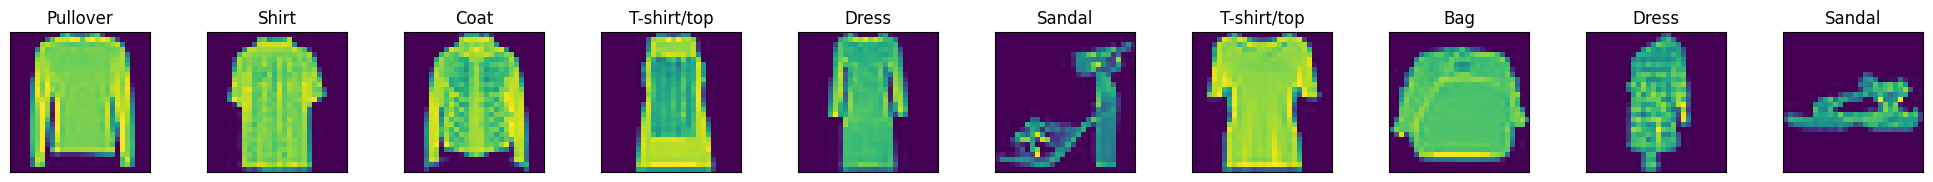

In [21]:
# visualizing images in gird
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert from tensor image

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() #converting images to numpy for display

fig = plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainset.classes[labels[idx]])

### Training Function:
This function trains the neural network model with stochastic gradient descent (SGD) as the optimizer and cross-entropy as the loss objective function.
The training process includes both forward and backward passes. The model's parameters are updated in each epoch.

### Testing Function:
After training the model, we'll evaluate the model's performance on testing dataset. The evaluation will be done based on the accuracy of the model, which is the proportion of correctly predicted samples.

In [28]:
class ModelTrainer:
    def __init__(self, model, learning_rate=1, num_epochs=100):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_loss = []
        self.test_loss = []

    def train_model(self, loader, epoch):
        self.model.train()
        loss_list = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            loss.backward()
            self.optimizer.step()
            loss_list.append(loss.item())
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx*len(data), len(loader.sampler),
                        100. * batch_idx / len(loader), loss.item()))
        avg_loss = sum(loss_list)/len(loss_list)
        self.train_loss.append(avg_loss)


    def test_model(self, loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        loss_list = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                batch_loss = self.loss_func(output, target).item()  # Calculate the loss for this batch
                test_loss += batch_loss  # Add the batch loss to the total test loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                loss_list.append(batch_loss)  # Append the batch loss to the list

        avg_loss = sum(loss_list) / len(loss_list)
        self.test_loss.append(avg_loss)
        test_loss /= len(loader)
        accuracy = 100. * correct / len(loader.sampler)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(loader.sampler), accuracy))

    def run(self, trainloader, validloader):
        for epoch in range(self.num_epochs):
            self.train_model(trainloader, epoch)
            self.test_model(validloader)
        self.plot_loss()


    # TODO: Generate a plot of the training/testing loss vs. the number of epochs. (10pts)
    def plot_loss(self):
        epochs = range(1, len(self.train_loss) + 1)
        plt.plot(epochs, self.train_loss, 'b-', label='Training Loss')
        plt.plot(epochs, self.test_loss, 'r-', label='Testing Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()
        pass


Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.139881

Test set: Average loss: 1.0777, Accuracy: 9490/12000 (79%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.082651

Test set: Average loss: 1.0403, Accuracy: 9978/12000 (83%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.020909

Test set: Average loss: 1.0410, Accuracy: 9946/12000 (83%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.105436

Test set: Average loss: 1.0173, Accuracy: 10093/12000 (84%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.029250

Test set: Average loss: 1.0056, Accuracy: 10246/12000 (85%)

Train Epoch: 5 [47936/48000 (100%)]	Loss: 0.928487

Test set: Average loss: 1.0111, Accuracy: 10117/12000 (84%)

Train Epoch: 6 [47936/48000 (100%)]	Loss: 0.980425

Test set: Average loss: 1.0013, Accuracy: 10270/12000 (86%)

Train Epoch: 7 [47936/48000 (100%)]	Loss: 1.006968

Test set: Average loss: 1.0085, Accuracy: 10184/12000 (85%)

Train Epoch: 8 [47936/48000 (100%)]	Loss: 0.906217

Test set: Average loss: 1.0047, Accuracy: 10258

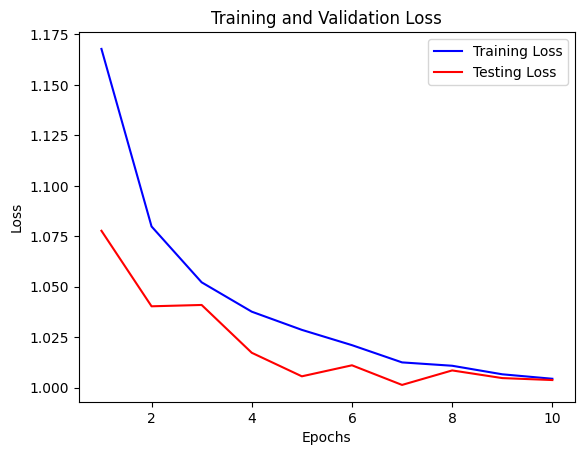


Test set: Average loss: 1.0203, Accuracy: 8439/10000 (84%)



In [29]:
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=10)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

#### Task 1: Visualize the model's correct and incorrect predictions on the testing dataset using a confusion Matrix.(10 pts)

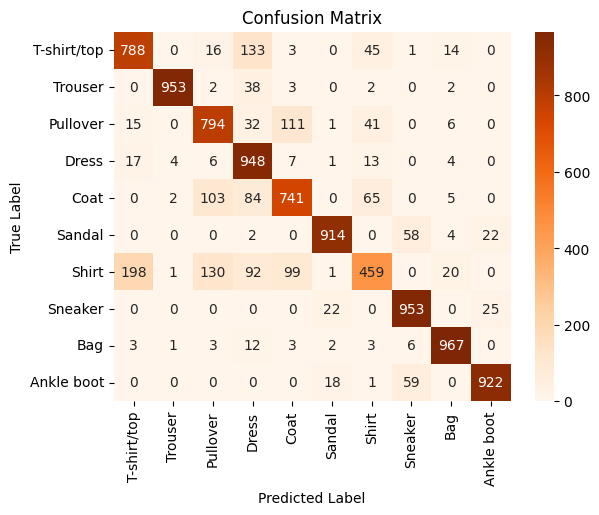

array([[788,   0,  16, 133,   3,   0,  45,   1,  14,   0],
       [  0, 953,   2,  38,   3,   0,   2,   0,   2,   0],
       [ 15,   0, 794,  32, 111,   1,  41,   0,   6,   0],
       [ 17,   4,   6, 948,   7,   1,  13,   0,   4,   0],
       [  0,   2, 103,  84, 741,   0,  65,   0,   5,   0],
       [  0,   0,   0,   2,   0, 914,   0,  58,   4,  22],
       [198,   1, 130,  92,  99,   1, 459,   0,  20,   0],
       [  0,   0,   0,   0,   0,  22,   0, 953,   0,  25],
       [  3,   1,   3,  12,   3,   2,   3,   6, 967,   0],
       [  0,   0,   0,   0,   0,  18,   1,  59,   0, 922]])

In [30]:
import seaborn as sns
def plot_confusion_matrix(model, loader, device, num_classes=10):
    model.eval()
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    classes = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)

            for t, p in zip(target.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1

    cm_numpy = cm.cpu().numpy()

    sns.heatmap(cm_numpy, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return cm_numpy


plot_confusion_matrix(trainer.model, testloader, trainer.device)

### Machine learning involves a lot of experimentation. You might not always see large improvements, but every observation helps you understand how different parameters and design choices affect the model's performance. Focus on interpreting the results, not just achieving the best accuracy.

#### Task 2: Experiment with different learning rates and report your observations. Explain why the model performs better with some learning rates and worse with others. (10 pts)

For example, Keeping the other parameters the same, pick a high learning rate and observe the lose curve, accuracy. Then pick a low learning rate and observe the lose curve, accuracy. Find an optimal learning rate for your model and explain How learning rate affects the accuracy and lose change? What is the reason for this change?

********Model with larger learning rate********
Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.430084

Test set: Average loss: 1.3560, Accuracy: 5990/12000 (50%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.275844

Test set: Average loss: 1.2980, Accuracy: 5421/12000 (45%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.201411

Test set: Average loss: 1.3117, Accuracy: 5549/12000 (46%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.345774

Test set: Average loss: 1.2647, Accuracy: 6715/12000 (56%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.412247

Test set: Average loss: 1.3379, Accuracy: 5418/12000 (45%)

Train Epoch: 5 [47936/48000 (100%)]	Loss: 1.224628

Test set: Average loss: 1.2444, Accuracy: 6499/12000 (54%)

Train Epoch: 6 [47936/48000 (100%)]	Loss: 1.225745

Test set: Average loss: 1.2692, Accuracy: 6380/12000 (53%)

Train Epoch: 7 [47936/48000 (100%)]	Loss: 1.371134

Test set: Average loss: 1.2837, Accuracy: 5709/12000 (48%)

Train Epoch: 8 [47936/48000 (100%)]	Loss: 1.224025

Test

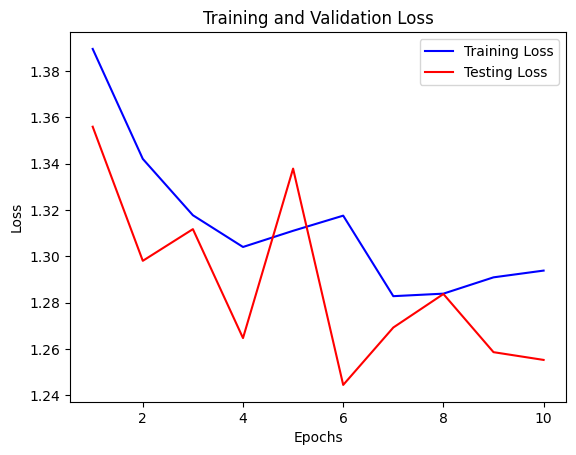


Test set: Average loss: 1.2612, Accuracy: 5411/10000 (54%)



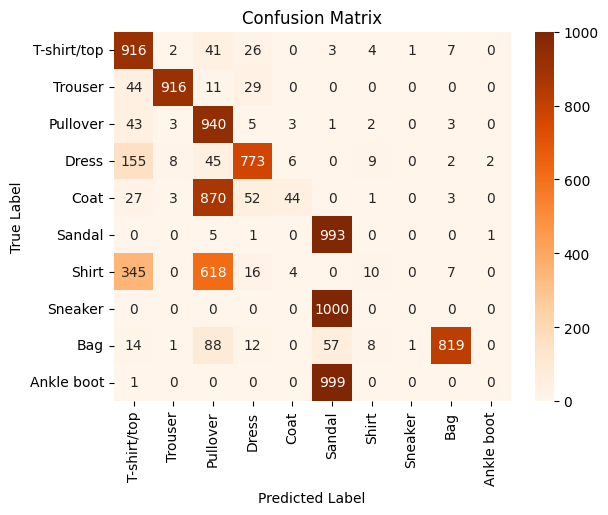

array([[ 916,    2,   41,   26,    0,    3,    4,    1,    7,    0],
       [  44,  916,   11,   29,    0,    0,    0,    0,    0,    0],
       [  43,    3,  940,    5,    3,    1,    2,    0,    3,    0],
       [ 155,    8,   45,  773,    6,    0,    9,    0,    2,    2],
       [  27,    3,  870,   52,   44,    0,    1,    0,    3,    0],
       [   0,    0,    5,    1,    0,  993,    0,    0,    0,    1],
       [ 345,    0,  618,   16,    4,    0,   10,    0,    7,    0],
       [   0,    0,    0,    0,    0, 1000,    0,    0,    0,    0],
       [  14,    1,   88,   12,    0,   57,    8,    1,  819,    0],
       [   1,    0,    0,    0,    0,  999,    0,    0,    0,    0]])

In [33]:
print("********Model with larger learning rate********")
model_larger_learning_rate = Classifier()
trainer_larger_learning_rate = ModelTrainer(model=model_larger_learning_rate, learning_rate=1.5, num_epochs=10)
trainer_larger_learning_rate.run(trainloader, validloader)
trainer_larger_learning_rate.test_model(testloader)
plot_confusion_matrix(trainer_larger_learning_rate.model, testloader, trainer_larger_learning_rate.device)


********Model with smaller learning rate********
Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.120419

Test set: Average loss: 1.0800, Accuracy: 9768/12000 (81%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.137420

Test set: Average loss: 1.0365, Accuracy: 10057/12000 (84%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 0.987387

Test set: Average loss: 1.0222, Accuracy: 10133/12000 (84%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.149498

Test set: Average loss: 1.0085, Accuracy: 10274/12000 (86%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.000275

Test set: Average loss: 1.0038, Accuracy: 10284/12000 (86%)

Train Epoch: 5 [47936/48000 (100%)]	Loss: 0.928422

Test set: Average loss: 0.9997, Accuracy: 10309/12000 (86%)

Train Epoch: 6 [47936/48000 (100%)]	Loss: 1.062376

Test set: Average loss: 0.9944, Accuracy: 10410/12000 (87%)

Train Epoch: 7 [47936/48000 (100%)]	Loss: 0.975516

Test set: Average loss: 0.9917, Accuracy: 10422/12000 (87%)

Train Epoch: 8 [47936/48000 (100%)]	Loss: 0.9875

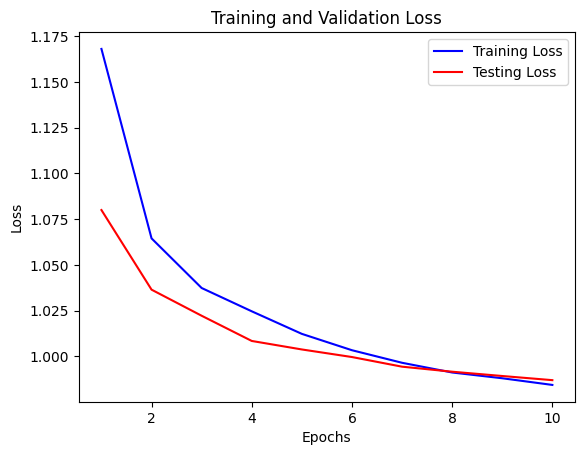


Test set: Average loss: 1.0039, Accuracy: 8556/10000 (86%)



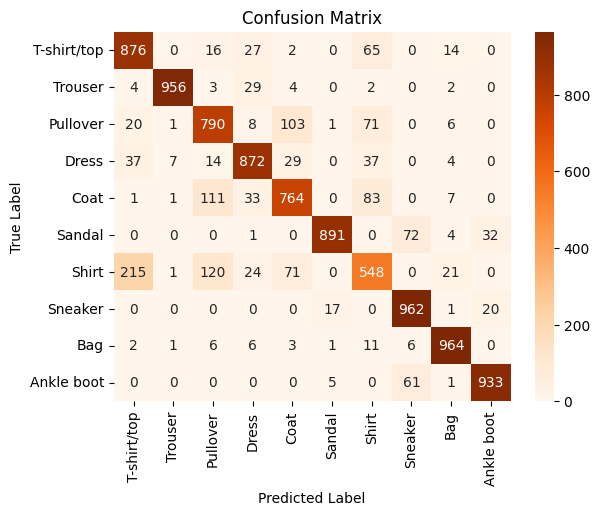

array([[876,   0,  16,  27,   2,   0,  65,   0,  14,   0],
       [  4, 956,   3,  29,   4,   0,   2,   0,   2,   0],
       [ 20,   1, 790,   8, 103,   1,  71,   0,   6,   0],
       [ 37,   7,  14, 872,  29,   0,  37,   0,   4,   0],
       [  1,   1, 111,  33, 764,   0,  83,   0,   7,   0],
       [  0,   0,   0,   1,   0, 891,   0,  72,   4,  32],
       [215,   1, 120,  24,  71,   0, 548,   0,  21,   0],
       [  0,   0,   0,   0,   0,  17,   0, 962,   1,  20],
       [  2,   1,   6,   6,   3,   1,  11,   6, 964,   0],
       [  0,   0,   0,   0,   0,   5,   0,  61,   1, 933]])

In [34]:
print("********Model with smaller learning rate********")
model_smaller_learning_rate = Classifier()
trainer_smaller_learning_rate = ModelTrainer(model=model_smaller_learning_rate, learning_rate=0.1, num_epochs=10)
trainer_smaller_learning_rate.run(trainloader, validloader)
trainer_smaller_learning_rate.test_model(testloader)
plot_confusion_matrix(trainer_smaller_learning_rate.model, testloader, trainer_smaller_learning_rate.device)

Task 2 report:
A learning rate of 0.1 works much better than 1.5, reaching a testing accuracy of 86%, while the latter only achieves 54%. This difference happens because the lower learning rate (0.1) allows for steady and gradual progress toward the minimum loss. In contrast, the higher learning rate (1.5) makes the model miss the best weights, resulting in ineffective learning and a fluctuatd loss curve.

#### Task 3: Experiment and report your observations on how the model's performance changes using *three* different activation functions. (10 pts)
Read more here: [Activation functions](https://machinelearningmastery.com/activation-functions-in-pytorch/)

In [37]:
class Classifier_with_activate_function(nn.Module):
    def __init__(self, activate_function):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)
        self.activate_function = activate_function

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(self.activate_function(self.fc1(x)))
        #not using dropout on output layer
        x = F.tanh(self.fc2(x))

        return x

Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.085904

Test set: Average loss: 1.0795, Accuracy: 9581/12000 (80%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.017496

Test set: Average loss: 1.0441, Accuracy: 10002/12000 (83%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 0.998015

Test set: Average loss: 1.0228, Accuracy: 10107/12000 (84%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.045857

Test set: Average loss: 1.0167, Accuracy: 10174/12000 (85%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.090497

Test set: Average loss: 1.0121, Accuracy: 10147/12000 (85%)



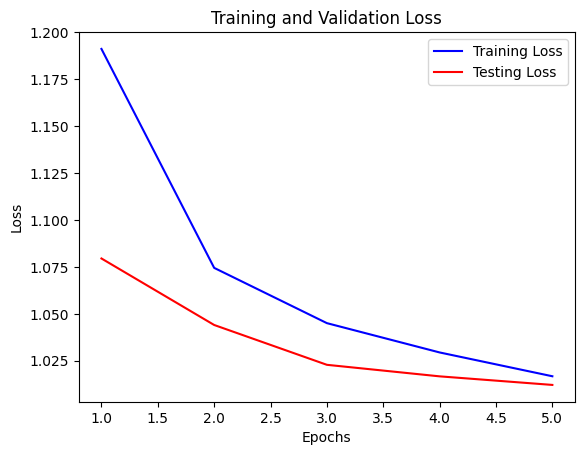


Test set: Average loss: 1.0282, Accuracy: 8362/10000 (84%)



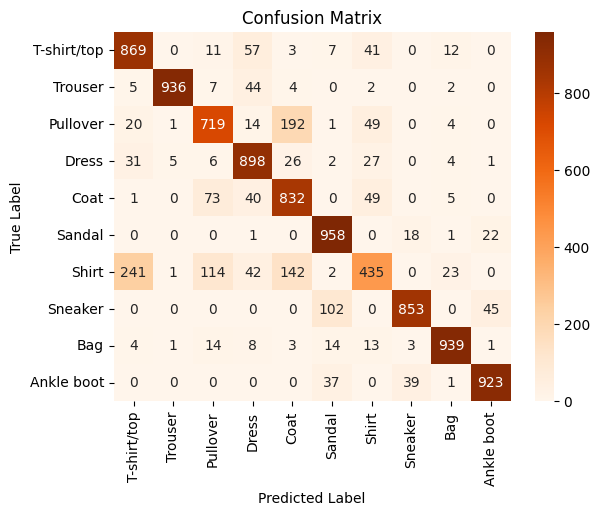

array([[869,   0,  11,  57,   3,   7,  41,   0,  12,   0],
       [  5, 936,   7,  44,   4,   0,   2,   0,   2,   0],
       [ 20,   1, 719,  14, 192,   1,  49,   0,   4,   0],
       [ 31,   5,   6, 898,  26,   2,  27,   0,   4,   1],
       [  1,   0,  73,  40, 832,   0,  49,   0,   5,   0],
       [  0,   0,   0,   1,   0, 958,   0,  18,   1,  22],
       [241,   1, 114,  42, 142,   2, 435,   0,  23,   0],
       [  0,   0,   0,   0,   0, 102,   0, 853,   0,  45],
       [  4,   1,  14,   8,   3,  14,  13,   3, 939,   1],
       [  0,   0,   0,   0,   0,  37,   0,  39,   1, 923]])

In [38]:
model_sigmoid = Classifier_with_activate_function(nn.Sigmoid())
trainer_sigmoid = ModelTrainer(model=model_sigmoid, learning_rate=0.5, num_epochs=5)
trainer_sigmoid.run(trainloader, validloader)
trainer_sigmoid.test_model(testloader)
plot_confusion_matrix(trainer_sigmoid.model, testloader, trainer_sigmoid.device)

Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.104178

Test set: Average loss: 1.0922, Accuracy: 9540/12000 (80%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.037999

Test set: Average loss: 1.0835, Accuracy: 9680/12000 (81%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.052136

Test set: Average loss: 1.0384, Accuracy: 10079/12000 (84%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.073828

Test set: Average loss: 1.0258, Accuracy: 10092/12000 (84%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.069144

Test set: Average loss: 1.0190, Accuracy: 10146/12000 (85%)



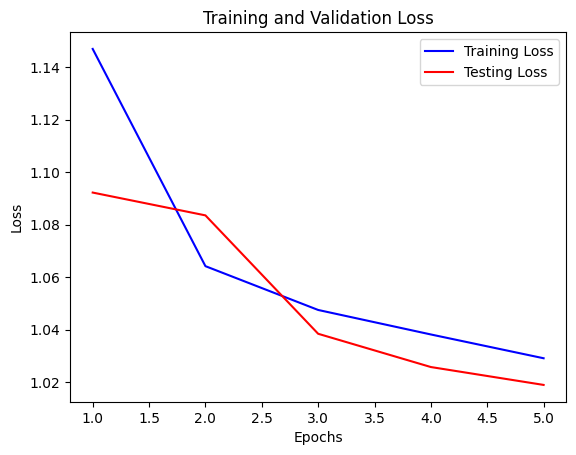


Test set: Average loss: 1.0369, Accuracy: 8329/10000 (83%)



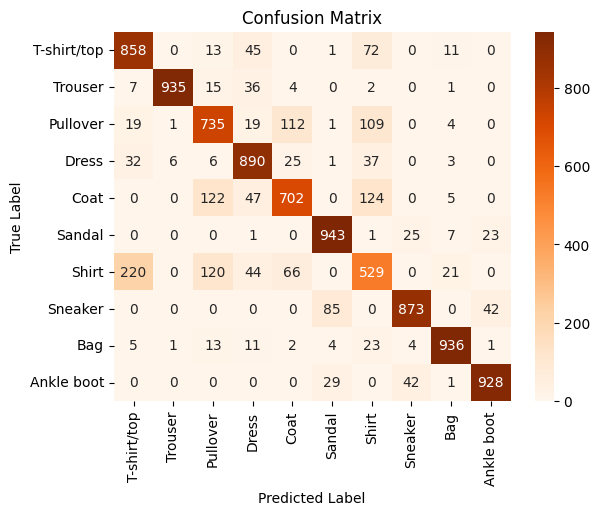

array([[858,   0,  13,  45,   0,   1,  72,   0,  11,   0],
       [  7, 935,  15,  36,   4,   0,   2,   0,   1,   0],
       [ 19,   1, 735,  19, 112,   1, 109,   0,   4,   0],
       [ 32,   6,   6, 890,  25,   1,  37,   0,   3,   0],
       [  0,   0, 122,  47, 702,   0, 124,   0,   5,   0],
       [  0,   0,   0,   1,   0, 943,   1,  25,   7,  23],
       [220,   0, 120,  44,  66,   0, 529,   0,  21,   0],
       [  0,   0,   0,   0,   0,  85,   0, 873,   0,  42],
       [  5,   1,  13,  11,   2,   4,  23,   4, 936,   1],
       [  0,   0,   0,   0,   0,  29,   0,  42,   1, 928]])

In [39]:
model_tanh = Classifier_with_activate_function(nn.Tanh())
trainer_tanh = ModelTrainer(model=model_tanh, learning_rate=0.5, num_epochs=5)
trainer_tanh.run(trainloader, validloader)
trainer_tanh.test_model(testloader)
plot_confusion_matrix(trainer_tanh.model, testloader, trainer_tanh.device)

Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.087928

Test set: Average loss: 1.0982, Accuracy: 9551/12000 (80%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.006265

Test set: Average loss: 1.0451, Accuracy: 9966/12000 (83%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.064006

Test set: Average loss: 1.0266, Accuracy: 10075/12000 (84%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.079288

Test set: Average loss: 1.0204, Accuracy: 10166/12000 (85%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.038039

Test set: Average loss: 1.0217, Accuracy: 10190/12000 (85%)



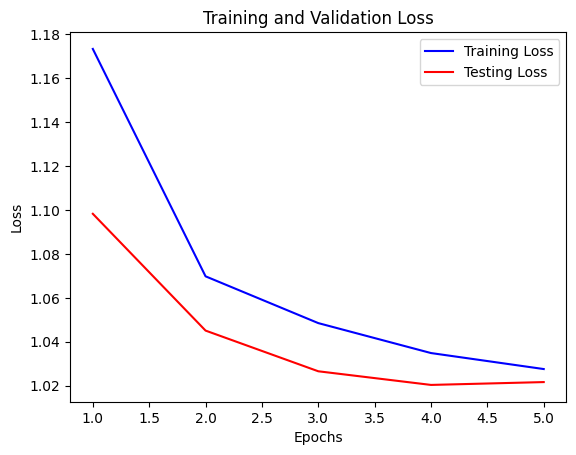


Test set: Average loss: 1.0389, Accuracy: 8348/10000 (83%)



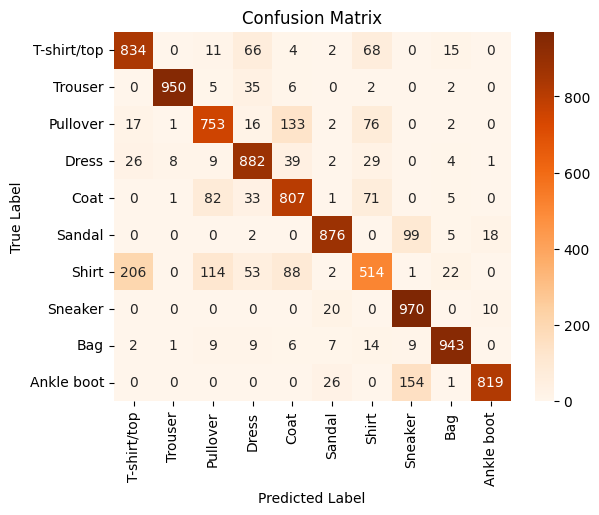

array([[834,   0,  11,  66,   4,   2,  68,   0,  15,   0],
       [  0, 950,   5,  35,   6,   0,   2,   0,   2,   0],
       [ 17,   1, 753,  16, 133,   2,  76,   0,   2,   0],
       [ 26,   8,   9, 882,  39,   2,  29,   0,   4,   1],
       [  0,   1,  82,  33, 807,   1,  71,   0,   5,   0],
       [  0,   0,   0,   2,   0, 876,   0,  99,   5,  18],
       [206,   0, 114,  53,  88,   2, 514,   1,  22,   0],
       [  0,   0,   0,   0,   0,  20,   0, 970,   0,  10],
       [  2,   1,   9,   9,   6,   7,  14,   9, 943,   0],
       [  0,   0,   0,   0,   0,  26,   0, 154,   1, 819]])

In [40]:
model_leakrelu = Classifier_with_activate_function(nn.LeakyReLU())
trainer_leakrelu = ModelTrainer(model=model_leakrelu, learning_rate=0.5, num_epochs=5)
trainer_leakrelu.run(trainloader, validloader)
trainer_leakrelu.test_model(testloader)
plot_confusion_matrix(trainer_leakrelu.model, testloader, trainer_leakrelu.device)

Task 3 report:
Based on the experimental results, Sigmoid was the most effective activation function. It achieved the highest testing accuracy of 84% with stable convergence and consistent performance across most categories. Similarly, Tanh and LeakyReLU both reached an accuracy of 83% but have more fluctuate on loss curve. All functions result in distinguishing between similar items, such as Pullovers and Coats, T-shirts/top as Shirts.




#### Task 4: Experiment and report your observations on how the model's performance(testing accuracy) changes with different numbers of hidden neurons and different number of hidden layers. (15 pts)
For example pick a hidden layer with 1000 neurons and report the accuracy. Then pick a hidden layer with 10 neurons and report the accuracy. How does the accuracy change, how long does it take for each iteration? What is the reason for this change?


Hidden Layers = [1000]
Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.305019

Test set: Average loss: 1.2938, Accuracy: 7091/12000 (59%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 1.559323

Test set: Average loss: 1.1397, Accuracy: 7611/12000 (63%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.062725

Test set: Average loss: 0.6912, Accuracy: 9011/12000 (75%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 0.791237

Test set: Average loss: 0.8711, Accuracy: 8748/12000 (73%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 0.341128

Test set: Average loss: 0.5598, Accuracy: 9792/12000 (82%)



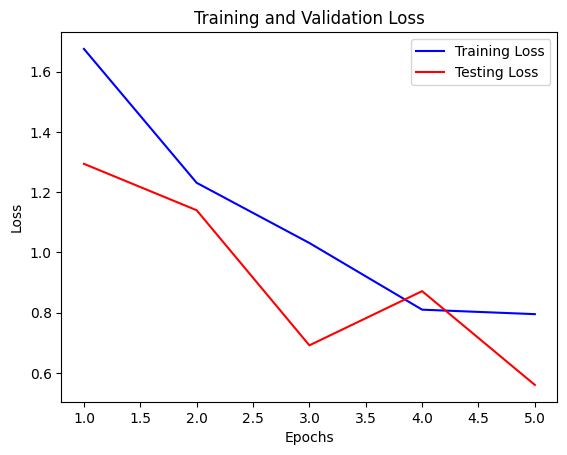

average epoch time: 18.71 sec

Test set: Average loss: 0.5836, Accuracy: 8085/10000 (81%)

Hidden Layers = [10]
Train Epoch: 0 [47936/48000 (100%)]	Loss: 3.124797

Test set: Average loss: 2.3668, Accuracy: 1178/12000 (10%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 2.226263

Test set: Average loss: 2.1080, Accuracy: 2150/12000 (18%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 1.994587

Test set: Average loss: 1.8035, Accuracy: 3505/12000 (29%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 2.129140

Test set: Average loss: 1.9555, Accuracy: 2708/12000 (23%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 1.996857

Test set: Average loss: 2.0651, Accuracy: 2301/12000 (19%)



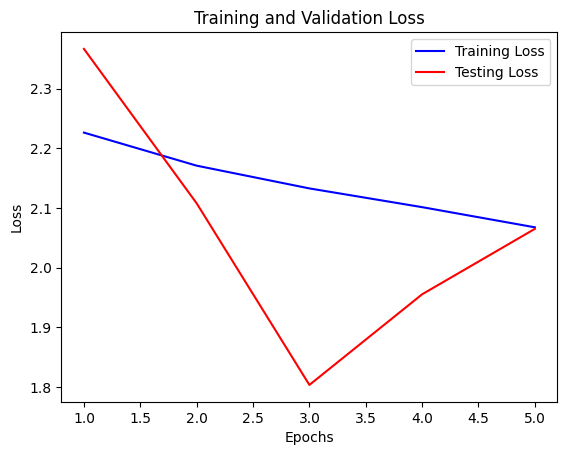

average epoch time: 13.52 sec

Test set: Average loss: 2.0651, Accuracy: 1886/10000 (19%)

Hidden Layers = [128]
Train Epoch: 0 [47936/48000 (100%)]	Loss: 1.921657

Test set: Average loss: 1.9445, Accuracy: 3322/12000 (28%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 2.304558

Test set: Average loss: 2.1880, Accuracy: 1978/12000 (16%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 2.085327

Test set: Average loss: 1.7449, Accuracy: 4138/12000 (34%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 1.737142

Test set: Average loss: 1.6834, Accuracy: 4347/12000 (36%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 2.218415

Test set: Average loss: 1.8288, Accuracy: 3845/12000 (32%)



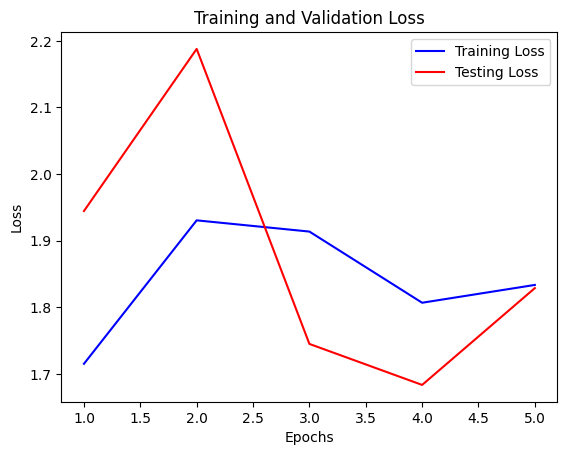

average epoch time: 14.11 sec

Test set: Average loss: 1.8347, Accuracy: 3176/10000 (32%)

Hidden Layers = [128, 128, 128]
Train Epoch: 0 [47936/48000 (100%)]	Loss: 0.766970

Test set: Average loss: 0.5730, Accuracy: 9491/12000 (79%)

Train Epoch: 1 [47936/48000 (100%)]	Loss: 0.700842

Test set: Average loss: 0.4686, Accuracy: 10002/12000 (83%)

Train Epoch: 2 [47936/48000 (100%)]	Loss: 0.376508

Test set: Average loss: 0.4704, Accuracy: 10030/12000 (84%)

Train Epoch: 3 [47936/48000 (100%)]	Loss: 0.697680

Test set: Average loss: 0.4514, Accuracy: 10078/12000 (84%)

Train Epoch: 4 [47936/48000 (100%)]	Loss: 0.412099

Test set: Average loss: 0.4404, Accuracy: 10134/12000 (84%)



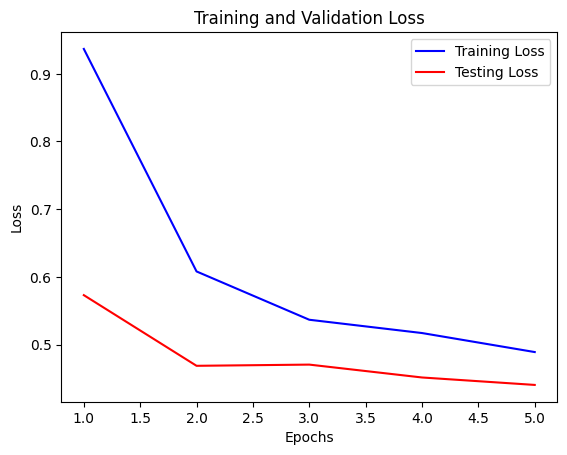

average epoch time: 14.86 sec

Test set: Average loss: 0.4700, Accuracy: 8363/10000 (84%)



In [41]:
class Classifier_flexible_hidden_layer(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[120], num_classes=10):
        super().__init__()
        self.layers = nn.ModuleList()

        current_dim = input_size
        for h_size in hidden_layers:
            self.layers.append(nn.Linear(current_dim, h_size))
            current_dim = h_size

        self.output = nn.Linear(current_dim, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = self.dropout(F.relu(layer(x)))
        x = self.output(x)
        return x

import time

def hidden_layer_experiment(hidden_config):
    print(f"Hidden Layers = {hidden_config}")
    model = Classifier_flexible_hidden_layer(hidden_layers=hidden_config)
    trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=5)

    start_time = time.time()
    trainer.run(trainloader, validloader)
    end_time = time.time()

    # average epoch time
    avg_epoch_time = (end_time - start_time) / trainer.num_epochs

    print(f"average epoch time: {avg_epoch_time:.2f} sec")
    trainer.test_model(testloader)

hidden_layer_experiment([1000])
hidden_layer_experiment([10])

hidden_layer_experiment([128])
hidden_layer_experiment([128, 128, 128])

Task 4 report:
Increasing the number of neurons and layers boosts model performance; as can be seen, accuracy jumped from 19% with 10 neurons to 81% with 1000 neurons and reached its peak of 84% by adding depth with three layers.
However, this improved accuracy comes at the cost of training time: from 13.52 seconds of the narrowest model to 18.71 seconds of the highest neuron counts, because higher model capacity allows more complex feature learning but requires more computational resources to process more parameters and matrix operations.

#### Task 5: What did you learn from these experiments? (10 pts)

Through these experiments, I learn that optimizing a neural network requires a balance between hyperparameter tuning and architectural design to manage the trade-off between accuracy and computational cost. I see that the learning rate is a critical factor; while a low rate (0.1) ensures stable convergence (82% accuracy), but a 0.5 rate gives higher accuracy (84%). I believe that this is because the step is too small to achieve higher accuracy. When I increase the number of epoch, the learning rate of 0.1 can reach the highest accuracy (86%). An excessively high rate (1.5) causes the model to miss the optimal weights, leading to poor performance (54% accuracy). I also find that the choice of activation function significantly impacts feature differentiation, with Sigmoid providing the most stable results. Finally, I learn that increasing model capacity—either by widening layers (from 10 to 1000 neurons) or increasing depth (from 1 to 3 layers)—dramatically improves accuracy from 19% to 84%, though it directly increases the computational time required per epoch.

## Exploring Real-World Behavior of Large Language Models

### Objective
In this section, you will study how real-world Large Language Model (LLM) tools behave when you change the way you ask questions.

Most students already use tools like ChatGPT. In this exercise, you will **analyze** these tools instead of only using them.  
The goal is to understand:
- How LLMs respond to different instructions
- How consistent their answers are
- How well they perform reasoning tasks
- When they are confident and when they are uncertain

### Part 1: Prompt Sensitivity and Consistency (8 pts)

###What you will do

You will compare how two different LLM tools respond to the same prompts.

####You must:

*   Choose two different web-based LLM tools
(for example: ChatGPT + Claude, ChatGPT + Gemini, Grok + Claude)
*   Ask the same prompts to both tools

#### Step 1: Choose a Question (Both Tools)
Choose one technical or conceptual question, for example:

- "How does attention work in transformer models?"
- "Why do large language models hallucinate?"
- "How does retrieval-augmented generation improve accuracy?"

#### Step 2: Basic Prompt (Both Tools)

Ask the question in a simple way, without extra instructions.

Example:

"How does attention work in transformer models?"

#### Step 3: Constrained Prompt (Both Tools)
Ask the same question again, but add **at least two clear instructions**, such as:
- "Explain using a simple example"
- "Write the answer in 5 bullet points"
- "Explain for a second-year computer science student"
- "Do not use equations"

#### Step 4: Consistency Check
Start a **new chat or session** and ask the same constrained prompt again.

#### What to analyze
Answer the following questions:
- Did the answers change between the two sessions?
- Did the tool follow your instructions?
- Which tool gave the most consistent answer?

### Part 2: Reasoning and Calculation (8 pts)

#### What you will do
In this part, you will intentionally test the limits of an LLM by finding a reasoning question where the model fails, makes a mistake, or gives a misleading explanation.

#### Step 1: Create a Reasoning Question
Comeup with one reasoning question that an LLM fails to answer correctly.

- Good questions often include:
- Percentages or comparisons
- Logical traps
- Ambiguous wording
- Multi-step reasoning

#### Step 2: Ask in Two Ways
Ask the same question in two different ways:
1. Ask for **only the final answer**
2. Ask for **step-by-step reasoning**

#### What to analyze
Answer the following questions:
- Did step-by-step reasoning improve the answer?
- Did any tool give a wrong answer with high confidence?
- Were the explanations clear and logically correct?


### Part 3: Confidence and Uncertainty (4 pts)

#### What you will do
In this part, you will study how LLMs behave when there is no single correct answer.

Some questions:

- Depend on context
- Have multiple valid viewpoints
- Are still debated by researchers

Good AI systems should acknowledge uncertainty instead of giving a confident but misleading answer.

Choose one question where the answer is not clear-cut or depends on assumptions.

You may use one of the examples below or create your own:

- "Is fine-tuning always better than retrieval-augmented generation?"
- "What is the best large language model architecture?"
- "Can large language models truly understand language?"
- "Should LLMs be used for high-stakes decision making?"
- Ask the same question to at least two different LLM tools.

#### What to analyze
Pay close attention to the tone and wording, not just the content.

Look for signs such as:

- Does the model say “it depends”?
- Does it explain what factors matter?
- Does it mention limitations or trade-offs?
- Does it ask for clarification before answering?

In a text cell or your report, answer the following:
- Did the model acknowledge uncertainty or ambiguity?
- Did it present one answer as clearly “correct”?
- Did any model sound overconfident?
- Which tool gave the most careful and balanced response?

### Submission Instructions

Submit a **short written report (1–2 pages)** that includes:
- The prompts you used
- Important parts of the model responses (copy and paste/ screenshots)
- Your analysis and observations

Screenshots are **optional** and should only be used if they help explain your analysis.

Grading will focus on:
- Clear explanations
- Correct technical understanding
- Thoughtful comparison between tools

We do **not** grade based on which tool is “best.”


## OpenAI API Setup Instructions

### Step 1: Create an OpenAI Account
Go to the [OpenAI website](https://openai.com/index/openai-api/) and create an account.
### Step 2: Get Your API Key
In the API dashboard, create a new API key.

Important:
- Keep your API key private
- Do not share it with others
- Do not upload it to GitHub or public files

Note:
- Using the API may require adding a payment method
- For this assignment, usage should cost very little
- You are charged based on the number of tokens used

Pricing details:
https://openai.com/api/pricing/

### Step 3: Install the OpenAI Python Client
You can install the OpenAI Python client using pip. Open your terminal and run the following command:
```console
pip install openai
```
### Step 4: Use the API Key in Your Application
Do not write your API key directly in the code.
In Google Colab, set it as an environment variable:

```python
import os
os.environ["OPENAI_API_KEY"] = "your-api-key-here"
```


### Step 5: Make API Calls
Below is a simple example that sends a prompt to an OpenAI model and prints the response.
#### For Text Generation
```python
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "Explain how attention works in transformer models."}
    ],
    temperature=0.7,
)

print(response.choices[0].message.content)
```

#### For Image Generation
```python
response = client.images.generate(
        model="dall-e-2",
        prompt= "Birthday cake with candles",
        n=1,
        size="1024x1024"
    )

That's it! You've successfully set up the OpenAI API.
For more Usages and examples refer the Docs Section
```

In [ ]:
pip install openai

## OpenAI Setup Assignment

### Part 1: Sentiment Analysis (5 pts)
In this part, you will use the OpenAI API to analyze the sentiment of user-provided text.
You will prompt a language model to classify the sentiment and explain its reasoning.

### Part 2: Image Generation (5 pts)
In this part, you will use the OpenAI API to generate an image from a text prompt.
You will design a prompt and observe how the generated image matches your description.

 ###  *Store your API key in a file called open_ai_key.txt and upload it on Colab or give path to the text file if you are running it locally*


In [ ]:
from google.colab import userdata
import os
open_ai_key = userdata.get('open_ai_key')
os.environ["OPENAI_API_KEY"] = open_ai_key

In [ ]:
from openai import OpenAI
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

class OpenAI_A0:
    def __init__(self):
        self.client = OpenAI()

    def get_sentiment(self, text):
        prompt = f"""
              Analyze the sentiment of the following text.
              Respond with one word: Positive, Negative, or Neutral.
              Text: "{text}"
        """
        response = self.client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )

        sentiment = response.choices[0].message.content
        print("Sentiment:", sentiment)

    def text_to_image(self):
        prompt = input("Enter a text prompt for image generation: ")

        response = self.client.images.generate(
            model="dall-e-2",
            prompt=prompt,
            size="1024x1024",
            n = 1
        )

        image_url = response.data[0].url
        image_bytes = requests.get(image_url).content
        image = Image.open(BytesIO(image_bytes))
        #image.show()
        display(image)

    def run(self):
        text = input("Enter text for sentiment analysis: ")
        self.get_sentiment(text)
        self.text_to_image()


Enter text for sentiment analysis: I am very excited to learn everything about LLM
Sentiment: Positive
Enter a text prompt for image generation: Give me a image of NFL team Seattle Seahawks fighting for Super Bowl


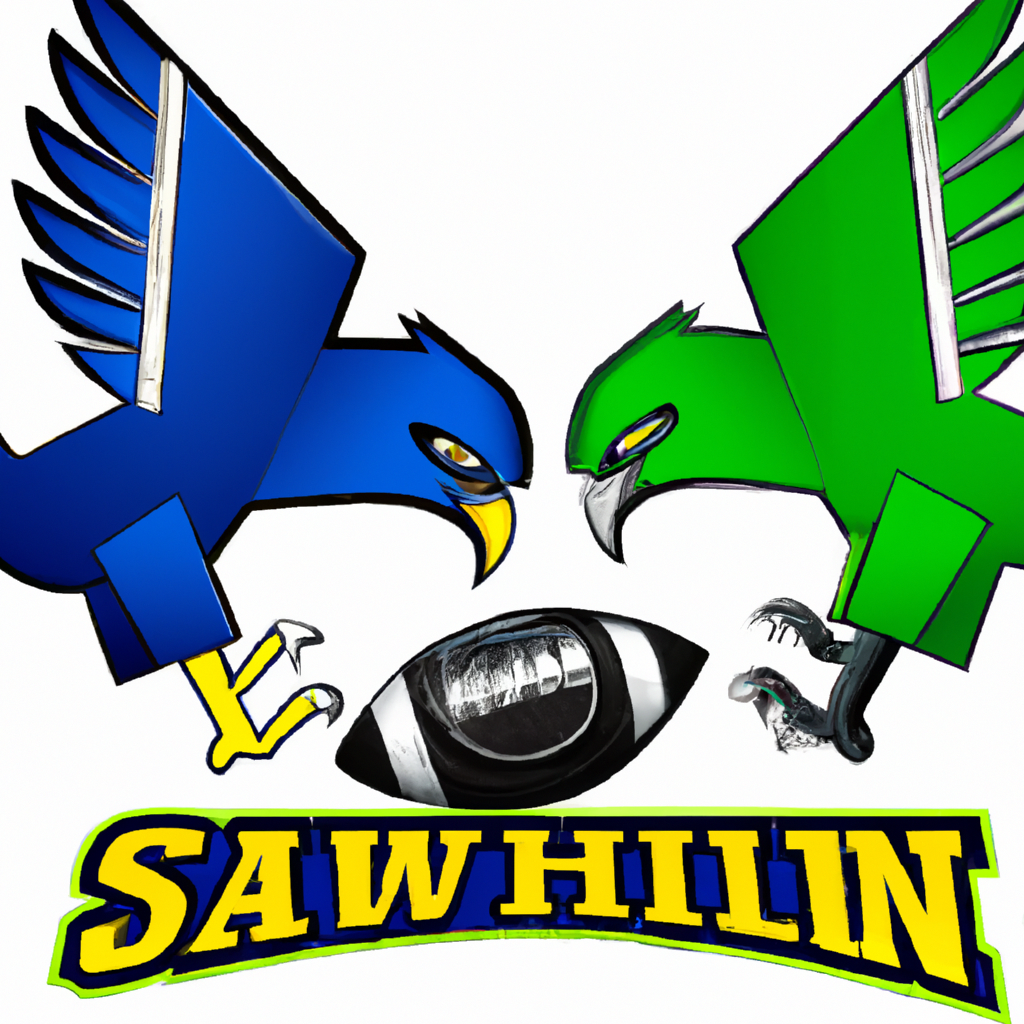

In [ ]:
if __name__ == "__main__":
    obj = OpenAI_A0()
    obj.run()

Part 1: Sentiment Analysis:

The model classified the input text as "Positive" because it recognized the emotional keyword "excited" paired with the word "very," which together signal a positive sentiment. Furthermore, the phrase "learn everything" reflects a proactive and enthusiastic attitude, reinforcing the overall optimistic tone. Since the sentence is straightforward and lacks any negation, the model successfully mapped the linguistic to the positive sentiment category.

Part 2: Image Generation:

While DALL-E 2 is able to recognize semantic color associations, it performs poorly when handling specific text labels and complex scenes, leading to text hallucinations. This shows the limitations of early generative models in achieving precise brand modeling and accurate linguistic rendering.

##Alternate key setup

###Hugging face API key setup (5 points)

Here we use Hugging Face Inference API to access a large language model called LLaMA-3-8B.
This option is free for limited usage and does not require a credit card.

You will learn how to:

*   Create an API token
*   Use a hosted LLM through an API
*   Send prompts and receive model responses

###Step 1: Create a Hugging Face Account

Go to the following link and create a free account:

https://huggingface.co/

###Step 2: Accept the LLaMA-3 License
LLaMA-3 models require accepting a license before use.


*   Open the model page: https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct
*   Click “Access repository”
*   Accept the license agreement

NOTE: This step is required. The API will not work if the license is not accepted.

###Step 3: Create an Access Token

*    Go to: https://huggingface.co/settings/tokens
*    Click New token
*    Select Read access
*    Copy and save the token (do not share it)

###Step 4: Install Required Libraries

Run the following command in a code cell:
```python
!pip install huggingface_hub
```

###Step 5: Set Your Token in Colab

In a code cell, run:
```python
import os
os.environ["HF_TOKEN"] = "your_huggingface_token_here"
```

###Step 6: Load the LLaMA-3-8B Model and Send a Prompt

Run the following in a code cell:
```python
from huggingface_hub import InferenceClient
import os

client = InferenceClient(
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    token=os.environ["HF_TOKEN"]
)

prompt = "Classify the sentiment of the following sentence: I really enjoyed this course."

response = client.text_generation(
    prompt,
    max_new_tokens=100,
    temperature=0.7
)

print(response)
```

In [1]:
!pip install huggingface_hub

## Alternate Key Setup

### Hugging Face API Key Setup (5 points)

Here we use Hugging Face Inference API to access a large language model.
This option is **free for limited usage** and does not require a credit card.

⚠️ **Important Notes:**
- Free tier: ~1000 requests/day
- Rate limits apply
- Some models require license approval (can take 24-48 hours)



### Step 1: Create a Hugging Face Account

1. Go to: https://huggingface.co/
2. Click "Sign Up" (top right)
3. Create account with email
4. Verify your email address



### Step 2: Choose a Model

**Option A: LLaMA-3.2 (Recommended - No License Required)**
- Model: `meta-llama/Llama-3.2-3B-Instruct`
- No approval needed
- Works immediately
- Good for assignments

**Option B: LLaMA-3.1 (Requires License)**
- Model: `meta-llama/Llama-3.1-8B-Instruct`
- Requires Meta approval (24-48 hours)
- Better quality
- Only if you have time to wait

For LLaMA-3.2 (No License - Start Here)
 **No action needed** - Skip to Step 4



### If you choose :  LLaMA-3.1 (License Required)

⚠️ **Only follow if using 3.1 model:**

1. Go to: https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct
2. Click "Agree and access repository"
3. Fill out Meta's form
4. **Wait 24-48 hours** for approval
5. Check email for approval confirmation

**Note:** If you need to complete assignment quickly, use LLaMA-3.2 instead.



### Step 4: Create an Access Token

1. Go to: https://huggingface.co/settings/tokens
2. Click "New token"
3. Name it (e.g., "ML_Assignment")
4. Select **"Read"** access (not "Write")
5. Click "Generate token"
6. **Copy and save** the token immediately
   - Format: `hf_...` (starts with `hf_`)
   - You won't see it again!


### Step 5: Install Required Libraries

Run in a code cell:
```python
!pip install huggingface_hub
```

### Step 6: Set Your Token in Colab

**Method 1: Direct (Quick Testing)**
```python
import os
os.environ["HF_TOKEN"] = "hf_your_actual_token_here"
```

**Method 2: From File (Recommended)**
```python
# Create a file 'hf_token.txt' with your token
with open('hf_token.txt', 'r') as f:
    token = f.read().strip()
os.environ["HF_TOKEN"] = token
```

**Method 3: Colab Secrets (Most Secure)**
```python
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
```


### Recommendation for Assignment:

1. **Quick completion**: Use LLaMA-3.2 (no license)
2. **Better quality**: Use OpenAI (requires payment)
3. **Free but patient**: Use LLaMA-3.1 (wait for approval)

 **Most students should start with LLaMA-3.2!**

In [8]:
from huggingface_hub import InferenceClient
import os

class HuggingFaceDemo:
    def __init__(self, token):
        self.client = InferenceClient(token=token)
        self.model = "meta-llama/Llama-3.2-3B-Instruct"

    def get_sentiment(self, text):
        """Analyze sentiment using HuggingFace API"""
        prompt = f"""Analyze the sentiment of this text.
              Respond with ONLY one word: Positive, Negative, or Neutral.

              Text: {text}

              Sentiment:"""

        #Using try except for better error handling
        try:
            """
            response = self.client.text_generation(
                prompt,
                model=self.model,
                max_new_tokens=10,
                temperature=0.1
            )

            response = self.client.chat.completions.create(
                model=self.model,
                messages=prompt,
                temperature=0.1,
                max_tokens=10
            )

            # Clean response
            sentiment = response.strip().split()[0]
            """

            response = self.client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=self.model,
                max_tokens=10,
                temperature=0.1
            )

            # Clean response
            sentiment = response.choices[0].message["content"].strip().split()[0]
            print(f"\nText: {text}")
            print(f"Sentiment: {sentiment}")
            return sentiment

        except Exception as e:
            print(f"Error: {e}")
            return None

    def test(self):
      #define text for sentiment analysis here
      text = "I am very excited in LLM course"
      self.get_sentiment(text)


# Usage
token = os.environ.get("HF_TOKEN_Read")
demo = HuggingFaceDemo(token)
demo.test()


Text: I am very excited in LLM course
Sentiment: Positive


### Additional Resources

### Troubleshooting Common Errors:

| Error | Cause | Solution |
|-------|-------|----------|
| `401 Unauthorized` | Invalid/missing token | Check token format (starts with `hf_`) |
| `403 Forbidden` | License not approved | Wait for approval or use 3.2 model |
| `429 Rate Limit` | Too many requests | Wait 1 hour, use free tier wisely |
| `503 Service Unavailable` | Model loading | Wait 30-60 seconds, retry |
| `Model not found` | Wrong model name | Copy exact name from HuggingFace |

---

### Free Tier Limits (As of 2025):
```
Daily Limits:
- ~1,000 API requests per day
- ~1 request per second
- No credit card required
- Resets every 24 hours

Rate Limits:
- Wait 1-2 seconds between requests
- Don't make 100+ calls in a loop
- Use wisely for assignment
```

---

### Comparison: OpenAI vs HuggingFace

| Feature | OpenAI | HuggingFace |
|---------|--------|-------------|
| **Free Tier** | No | Yes |
| **Credit Card** | Required | Not required |
| **Setup Time** | 5 min | 5 min (3.2) / 48 hrs (3.1) |
| **Quality** | Excellent | Good |
| **Rate Limits** | Pay per use | 1000/day free |
| **Best For** | Production | Learning/Testing |
